### Install the `torchmetrics` library for evaluation.

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics.classification import Accuracy
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_CLASSES = 10

In [5]:
def load_data(T, batch_size):
  train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=T)
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=T)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [6]:
def plot_results(train_losses, test_losses, test_accuracies):
  """
  Plot the train and test losses and accuracy values over a number of epochs.
  """
  fig, ax = plt.subplots(1, 2, figsize=(9, 3))

  ax[0].plot(train_losses, label='Train Loss')
  ax[0].plot(test_losses, label='Test Loss', color='red')
  ax[0].legend()
  ax[1].plot([value for value in test_accuracies], label='Test Accuracy', color='green')

  ax[0].set_title('Train / Test Loss')
  ax[1].set_title('Test Accuracy')

  plt.show()

# Q1. Complete the following implementations:
- `train_epoch`
- `eval_model`
- `run_experiment`
- `SimpleCNN`
- `ResNet50Transfer`
- `VGGTransfer`


In the following functions, you are training and evaluating the model for just one epoch (One full pass through the dataset). Complete the `train_epoch` and `eval_model` functions.

In [7]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    # set the model to training e.g. enable dropouts
    model.train()
    running_loss = 0.0

    # Iterate through the batch of samples in the train set
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # zero the previously calculated gradients
        # make predictions
        # calculate the loss
        # calculate the gradient of the loss
        # adjust the model parameters based on the gradient
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # keep track of the loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    # return the average of the loss over all of the batches
    return train_loss

def eval_model(model, test_loader, criterion, acc, device):
    """
    Evaluate the model on the test set.
    """
    # set the model to eval mode e.g. disable dropouts
    model.eval()
    running_loss = 0.0
    # reset the calculated accuracy object
    acc.reset()

    # make sure the following does not affect the gradient calculation
    with torch.no_grad():
        # Iterate through the batch of samples in the test set
        for images, labels in test_loader:
           # make predictions
           # calculate the loss
           # keep track of the loss
           # update the overall accuracy by including the accuracy of this batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            acc.update(outputs, labels)
    # return:
    # the average loss over the test set
    # the accuracy over the test set
    test_loss = running_loss / len(test_loader)
    test_acc = acc.compute().item()
    return test_loss, test_acc


In the following function you will use the previous function to train the model over a number of epochs. Complete the `run_experiment` function.

In [8]:
def run_experiment(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
  """
  Run the experiment for a given number of epochs.

  args:
    model: torch.nn.Module, the model to train
    train_loader: torch.utils.data.DataLoader, the dataloader for the training set
    test_loader: torch.utils.data.DataLoader, the dataloader for the test set
    optimizer: torch.optim.Optimizer, the optimizer to use
    criterion: torch.nn.Module, the loss function to use
    device: torch.device
    epochs: int, the number of epochs to train for

  returns:
    train_losses: list of floats, the train loss for each epoch
    test_losses: list of floats, the test loss for each epoch
    accuracies: list of floats, the test accuracy for each epoch
  """
  train_losses = []
  test_losses = []
  accuracies = []

  acc = Accuracy('multiclass', num_classes=NUM_CLASSES).to(device) # Initialize the accuracy object

  # Interate through the number of epochs
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model (using the `train_epoch` function)
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    # Keep track of the training loss for this epoch
    train_losses.append(train_loss)

    # Evaluate the model (using the `eval_model` function)
    test_loss, test_acc = eval_model(model, test_loader, criterion, acc, device)
    # Keep track of the testing loss and the testing accuracy for this epoch
    test_losses.append(test_loss)
    accuracies.append(test_acc)
    # Print them
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

  print("Finished training.")
  # return:
    # train_losses: list of floats, the train loss for each epoch
    # test_losses: list of floats, the test loss for each epoch
    # accuracies: list of floats, the test accuracy for each epoch
  return train_losses, test_losses, accuracies

In [9]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Convolution(3x3 kernel) channels: 3 -> 32
    # ReLU
    # Max pooling (2x2)
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Convolution(3x3 kernel) channels: 32 -> 64
    # ReLU
    # Max pooling (2x2)
    self.conv2 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Convolution(3x3 kernel) channels: 64 -> 128
    # ReLU
    # Max pooling (2x2)
    self.conv3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Linear 512 hidden_dim
    # ReLU
    # Linear output -> num_classes
    self.fc1 = nn.Sequential(
      nn.Linear(128 * 4 * 4, 512),
      nn.ReLU()
    )

    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    # make the output flat
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [10]:
class ResNet50Transfer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Initialize Resnet 50 with the default weights
        self.resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Freeze the resnet weights
        for param in self.resnet50.parameters():
            param.requires_grad = False

        # replace the last fully connected layers with the following:
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            # Linear 256 hidden_dim
            nn.Linear(in_features, 256),
            # ReLU
            nn.ReLU(),
            # Linear output -> num_classes
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)


In [11]:
class VGGTransfer(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Initialize VGG16 with the default weights
        self.vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

        # Freeze the feature weights
        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        # Replace the classifier with the following:
        self.vgg16.classifier = nn.Sequential(
            # Linear 256 hidden_dim
            nn.Linear(25088, 256),
            # ReLU
            nn.ReLU(),
            # Linear output -> num_classes
            nn.Linear(256, num_classes)  # Output layer with num_classes
        )

    def forward(self, x):
        return self.vgg16(x)


# Q2. Run the following experiments and report the results.
- Train and evaluate the `SimpleCNN` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis.

In [12]:
T = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, test_loader = load_data(T, BATCH_SIZE)
simple_cnn = SimpleCNN(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(simple_cnn, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Epoch 1/5
Train Loss: 1.6802, Test Loss: 1.4682, Test Accuracy: 0.4598
Epoch 2/5
Train Loss: 1.3991, Test Loss: 1.3157, Test Accuracy: 0.5282
Epoch 3/5
Train Loss: 1.2838, Test Loss: 1.2284, Test Accuracy: 0.5561
Epoch 4/5
Train Loss: 1.1947, Test Loss: 1.1696, Test Accuracy: 0.5816
Epoch 5/5
Train Loss: 1.1220, Test Loss: 1.0923, Test Accuracy: 0.6120
Finished training.


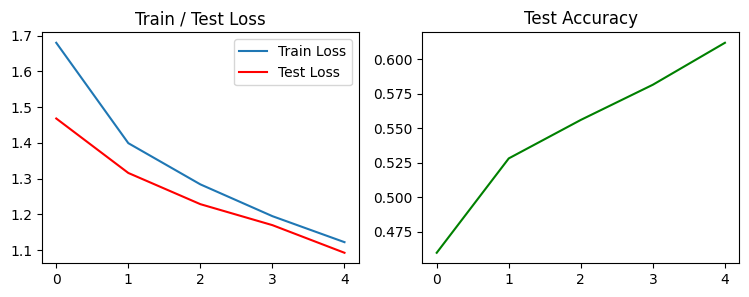

In [13]:
plot_results(train_losses, test_losses, accuracies)

# Analysis
Both train and test loss decreases from 1.6802 to 1.1220 and 1.4682 to 1.0923 respectively.

The accuracy increases from 0.4598 to 0.6120.

This shows consistent improvement of 5 epochs, however still not as effective as ResNet50 that is seen below.

Deeper layers would be suggested in order to improve these results.


# Q3. Run the following experiments and report the results.
- Train and evaluate the `ResNet50_Weights` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis. Make comparisons to the previous experiments when appropriate.

In [14]:
T = ResNet50_Weights.DEFAULT.transforms()
train_loader, test_loader = load_data(T, BATCH_SIZE)

resnet_transfer = ResNet50Transfer(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(resnet_transfer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(resnet_transfer, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


Epoch 1/5
Train Loss: 0.9590, Test Loss: 0.6703, Test Accuracy: 0.7758
Epoch 2/5
Train Loss: 0.6453, Test Loss: 0.6258, Test Accuracy: 0.7836
Epoch 3/5
Train Loss: 0.6005, Test Loss: 0.5821, Test Accuracy: 0.7932
Epoch 4/5
Train Loss: 0.5787, Test Loss: 0.5695, Test Accuracy: 0.8056
Epoch 5/5
Train Loss: 0.5634, Test Loss: 0.5593, Test Accuracy: 0.8068
Finished training.


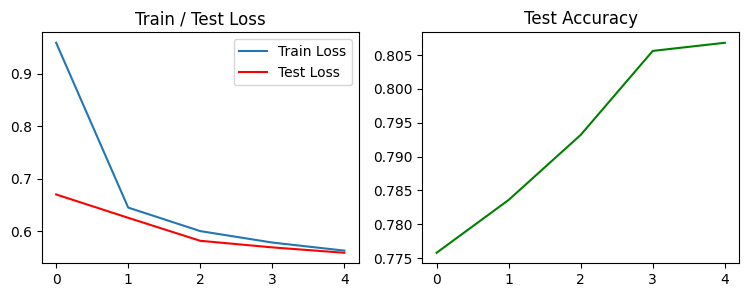

In [15]:
plot_results(train_losses, test_losses, accuracies)

# Analysis
For 5 epochs

Consistent decrease in both train and test loss from 0.9590 to 0.5634 and 0.6703 to 0.5593 respectively.

The accuracy however increases from 0.7758 to 0.8068

Due to the decrease of the train and test losses, more epochs would further more improve the accuracy, or a lower learning rate


With CIFAR-10 image classification, ResNet50 was effective with transfer learning


# Q4. Run the following experiments and report the results.
- Train and evaluate the `VGGTransfer` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis. Make comparisons to the previous experiments when appropriate.

In [16]:
T = VGG16_Weights.DEFAULT.transforms()
train_loader, test_loader = load_data(T, BATCH_SIZE)

vgg_transfer = VGGTransfer(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(vgg_transfer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(vgg_transfer, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.5MB/s]


Epoch 1/5
Train Loss: 0.4810, Test Loss: 0.4176, Test Accuracy: 0.8576
Epoch 2/5
Train Loss: 0.2038, Test Loss: 0.4058, Test Accuracy: 0.8625
Epoch 3/5
Train Loss: 0.1037, Test Loss: 0.4330, Test Accuracy: 0.8654
Epoch 4/5
Train Loss: 0.0483, Test Loss: 0.4639, Test Accuracy: 0.8650
Epoch 5/5
Train Loss: 0.0217, Test Loss: 0.4960, Test Accuracy: 0.8637
Finished training.


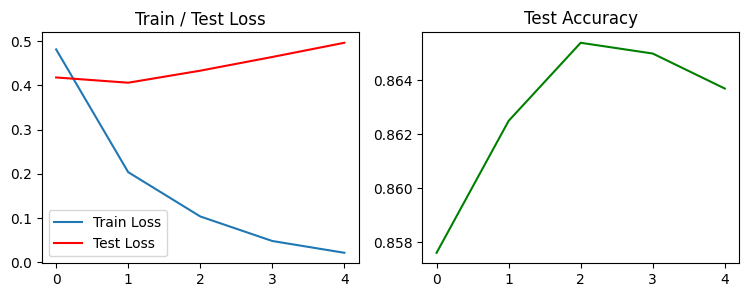

In [17]:
plot_results(train_losses, test_losses, accuracies)

# Analysis

The train loss decreases from 0.4810 all the way to 0.0217, which indicates that this model had been trained effectively.

The test loss decreases from 0.4176 to 0.4058 then quickly jumps back up consistently all the way to 0.4960, which could be a cause of overfitting

The accuracy had consistently increases little by little from 0.8576 to 0.8637, which means it is generalizing well with new data.

In order to reduce the overfitting caused in the test loss decrease, we could apply data augmentation or early stopping


